# impedance measurement based on Mommertz Correlation method
Please note that this is not a Python tutorial. We assume that you are aware of basic Python coding and concepts including the use of ``conda`` and ``pip``. If you did not install pyfar already please do so by running the command

``pip install mesh2scattering``

After this go to your Python editor of choice and import mesh2scattering. We will also import a couple of other things, which we will need later.


In [71]:
import mesh2scattering as m2s
import pyfar as pf
import os
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import sofar as sf
# %matplotlib ipympl


The correlation method by Mommertz can calculate the scattering coefficient (or the specular reflection factor) based on the reflected sound pressure of finite surfaces with same outer dimensions:
- p_0 the reference surface of s sound hard flat circular sample
- p_1 the sample surface under investigation 

```
E. Mommertz, “Determination of scattering coefficients from the reflection directivity of architectural surfaces,” Applied Acoustics, vol. 60, no. 2, pp. 201–203, Jun. 2000, doi: 10.1016/S0003-682X(99)00057-2.
```

In this example we will use the same flat surface for both pressure, but for the sample surface we define a custom impedance, and we hope to get that at the end of the Mommertz correlation method.

## create the project

first we need the meshes to simulate $p_0$ and $p_1$. We set the path of the meshes, we will use the flat reference surface for both, but we will set a custom surface impedance for the sample mesh. Please notice that the sample should lay on the x-y-plane where z is the hight.

In [72]:
sample_path = os.path.join('meshes', 'reference_n10_1', 'sample.stl')
reference_path = os.path.join('meshes', 'reference_n10_1', 'sample.stl')
project_path = os.path.join(os.getcwd(), 'project_impedance')
if not os.path.isdir(project_path):
    os.mkdir(project_path)

Define the frequency array. For simplicity we just use 4 frequencies. 
If you want to create 3rd- or 1st octave band frequencies have a look on ``pyfar.dsp.filter.fractional_octave_frequencies``.

In [73]:
frequencies = np.array([500, 1000, 2000, 3000, 4000])

Now we need to define the source and receiver positions. Therefore we create a sampling grid, including the pole and removing the lower part of the spherical grid.

/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_6829/3296080726.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  receiverPoints = pf.samplings.sph_gaussian(
/Users/anne/miniconda3/envs/mesh2scattering/lib/python3.13/site-packages/pyfar/samplings/samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
/Users/anne/miniconda3/envs/mesh2scattering/lib/python3.13/site-packages/pyfar/classes/coordinates.py:265: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


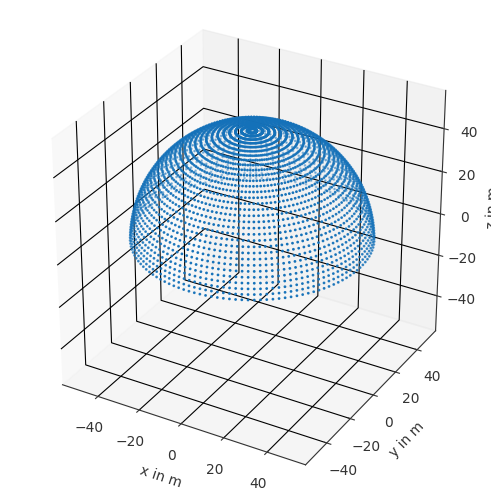

In [74]:
receiver_radius = 50
receiverPoints = pf.samplings.sph_gaussian(
    sh_order=63, radius=receiver_radius)
receiverPoints = receiverPoints[receiverPoints.colatitude < np.pi/2]
receiverPoints.show()
plt.show()

The receiver positions can now go into its related class. The class requires faces, but they can be simply calculated by the class by using ``from_spherical``.

In [75]:
evaluation_grid = m2s.input.EvaluationGrid.from_spherical(
    receiverPoints, 'grid')

Same for the source positions. The radius does not matter here, because we will use plane wave incident.

<Figure size 640x480 with 0 Axes>

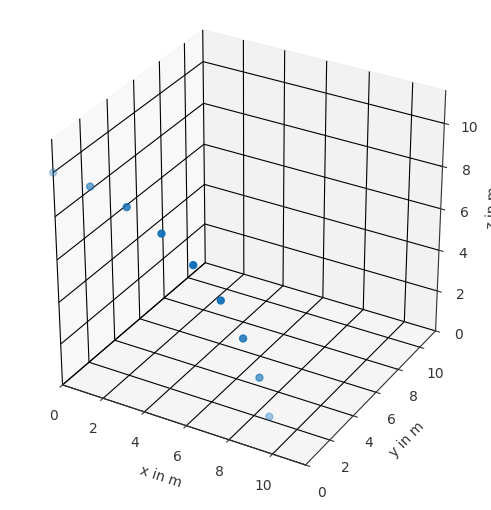

In [76]:
source_radius = 10
sourcePoints = pf.Coordinates.from_spherical_colatitude(
    0, np.arange(0, 90, 10)*np.pi/180, source_radius)
sourcePoints.weights = np.cos(sourcePoints.elevation)
plt.figure()
sourcePoints.show()
plt.show()

Now we need to set the parameters of the sample. 

In [77]:
structural_wavelength = 0
sample_diameter = 0.8
model_scale = 1
sample_baseplate_hight = 0.01

Furthermore we need to define the symmetry properties of the sample. In our case it is rotationally symmetric, for both surfaces.

In [78]:
symmetry_azimuth = []
symmetry_rotational = True

Lets collect all the metadata of the sample and the surface into the related class object.
The meta data will not influence the simulation or postprocessing, they are just collected and exported in the sofa file at the end.

In [79]:
impedance_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=structural_wavelength,
    structural_wavelength_y=0,
    structural_depth=0,
    surface_type=m2s.input.SurfaceType.PERIODIC,
    symmetry_azimuth=symmetry_azimuth,
    symmetry_rotational=symmetry_rotational,
)

reference_description = m2s.input.SurfaceDescription(
    structural_wavelength_x=0,
    structural_wavelength_y=0,
    structural_depth=0,
    surface_type=m2s.input.SurfaceType.FLAT,
    symmetry_azimuth=[],
    symmetry_rotational=True,
)


The normalized impedance is defined as $Z_n = Z/(rho_0*c)$, where Z is the surface impedance and $rho_0*c$ are the density of air and the speed of sound. We defines $Z_n=4$ here. which results in a reflection factor of $R=(Z_n - 1)/(Z_n + 1)=0.6$.

In [80]:
sample_mesh = trimesh.load(sample_path)
n_faces = sample_mesh.faces.shape[0]
alpha = 0.5  # Absorption coefficient
R= np.sqrt(1-alpha)
Z_n = 4
R = (Z_n - 1)/(Z_n + 1)
alpha = 1 - np.abs(R)**2
print(f'Z: {Z_n}; alpha: {alpha}, R: {R}')

Z: 4; alpha: 0.64, R: 0.6


We define a boundary condition as impedance for all frequencies and add the impedance to the upper surface of the mesh.

In [81]:
bc = m2s.input.bc.BoundaryCondition(
    Z_n,
    m2s.input.bc.BoundaryConditionType.impedance,
)
normals_z = sample_mesh.face_normals[:, 2]
mask = normals_z > .9

indexes = np.where(mask)[0]
assert all(np.abs(np.diff(indexes)-1) < 1e-5)
bcm = m2s.input.bc.BoundaryConditionMapping(n_faces)
bcm.add_boundary_condition(
    bc, int(np.min(indexes)), int(np.max(indexes)), # Apply to upper surface
)

Lets have a look at the mesh and its material assignment. Red indicates the custom impedance and grey the sound hard surface.

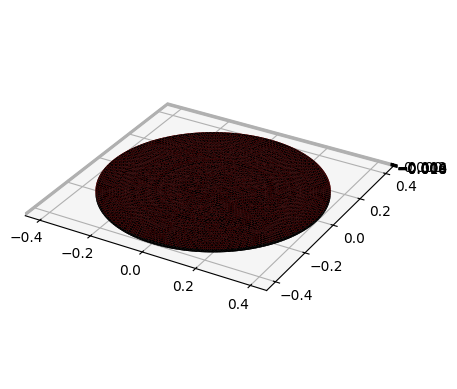

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(
    sample_mesh.vertices[:, 0], sample_mesh.vertices[:,1],
    triangles=sample_mesh.faces[mask],
    Z=sample_mesh.vertices[:,2], color='red')
ax.plot_trisurf(
    sample_mesh.vertices[:, 0], sample_mesh.vertices[:,1],
    triangles=sample_mesh.faces[False==mask],
    Z=sample_mesh.vertices[:,2], color='black')
ax.set_aspect('equal')
plt.show()

now we combine the mesh, impedance and the surface information into SampleMesh object for both simulations.

In [83]:

mesh_impedance = m2s.input.SampleMesh(
    mesh=sample_mesh,
    surface_description=impedance_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
    bc_mapping=bcm,
)
mesh = trimesh.load(reference_path)

mesh_reference = m2s.input.SampleMesh(
    mesh=mesh,
    surface_description=reference_description,
    sample_baseplate_hight=0.01,
    sample_diameter=sample_diameter,
    sample_shape=m2s.input.SampleShape.ROUND,
)


Now we can add put the source positions into the correct class formate. We will define Plane waves.

In [84]:
plane_wave_direction = sourcePoints.copy()
plane_wave_direction.cartesian *= -1
sound_sources = m2s.input.SoundSource(
    source_coordinates=plane_wave_direction,
    source_type=m2s.input.SoundSourceType.PLANE_WAVE,
)

let's plot the scene

<Figure size 640x480 with 0 Axes>

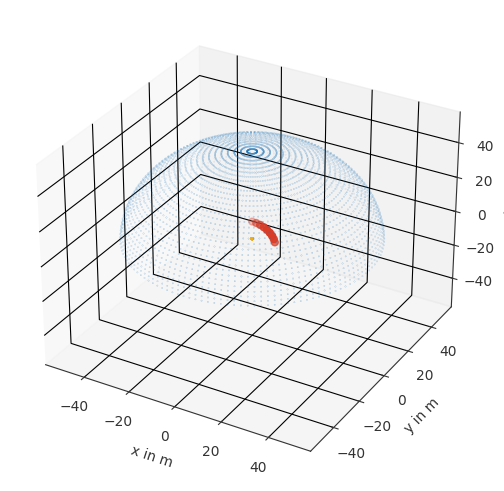

In [85]:
sample = trimesh.load_mesh(sample_path).vertices
sample_coords = pf.Coordinates(sample[:, 0],sample[:, 1],sample[:, 2])
plt.figure()
ax = pf.plot.scatter(receiverPoints, s=1/20)
pf.plot.scatter(sourcePoints, ax=ax)
pf.plot.scatter(sample_coords, ax=ax, s=1/72)
plt.show()


Now we can create the project. Please notice that the project was already created and simulated for demo.

In [86]:
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'impedance'),
    project_title='impedance',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_impedance,
    )
m2s.input.write_scattering_project_numcalc(
    project_path=os.path.join(project_path, 'reference'),
    project_title='reference',
    frequencies=frequencies,
    sound_sources=sound_sources,
    evaluation_grids=[evaluation_grid],
    sample_mesh=mesh_reference,
    )

## run project
To execute the project you need to build the ``NumCalc`` project. If you use Windows, the exe can be directly downloaded and on mac or linux it can be build, see the function documentation for more information.

In [87]:
numcalc_path = m2s.numcalc.build_or_fetch_numcalc()

Now we can run the simulation, this may take some time. This example is already simulated so we don't need to wait. If we don't explicitly define then ``numcalc_path`` it will use ``m2s.numcalc.build_or_fetch_numcalc()`` in the background to determine the numcalc_path.

In [88]:
m2s.numcalc.manage_numcalc(
    os.path.join(os.getcwd(), project_path), wait_time=1)


Starting manage_numcalc with the following arguments [Jun 05 2025, 13:39:35]
----------------------------------------------------------------------------
project_path: /Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance
numcalc_path: /Users/anne/git/_pyfar/Mesh2scattering/mesh2scattering/numcalc/bin/NumCalc
max_ram_load: 16.00 GB (16.00 GB detected, 7.18 GB available)
ram_safety_factor: 1.05
max_cpu_load: 90 %
max_instances: 8 (8 cores detected)
wait_time: 1 seconds
starting_order: alternate
confirm_errors: False


Per project summary of instances that will be run
-------------------------------------------------
Detected 2 NumCalc projects in
/Users/anne/git/_pyfar/Mesh2scattering/examples/project_impedance


'impedance' is already complete
'reference' is already complete


... waiting for the last NumCalc instances to finish (checking every second, Jun 05 2025, 13:39:35)

All NumCalc projects finished at Jun 05 2025, 13:39:35


## Post processing
Now we need to create the scattering pattern sofa files out of the simulation results. We are basically just writing the results into a dedicated sofa file.

In [89]:
m2s.output.write_pressure(os.path.join(project_path, 'impedance'))
m2s.output.write_pressure(os.path.join(project_path, 'reference'))


 Writing the project report ...

 Writing the project report ...


## Read and plot data
lets read the the sofa files with sofar and pyfar.

In [90]:
# calculate r_spec after Mommertz
p_1_sofa = sf.read_sofa(
    os.path.join(project_path, 'impedance_grid.pressure.sofa'))
p_2_sofa =sf.read_sofa(
    os.path.join(project_path, 'reference_grid.pressure.sofa'))
pressure_1, _, _ = pf.io.convert_sofa(p_1_sofa)
pressure_0, sources, receivers = pf.io.convert_sofa(p_2_sofa)
sources.weights = p_1_sofa.SourceWeights
receivers.weights = p_1_sofa.ReceiverWeights


SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational
SOFA file contained custom entries
----------------------------------
OriginalFrequencies, RealScaleFrequencies, Lbyl, SampleStructuralWavelength, SampleStructuralWavelengthX, SampleStructuralWavelengthY, SampleModelScale, SampleDiameter, SpeedOfSound, DensityOfMedium, ReceiverWeights, SourceWeights, SampleSymmetryAzimuth, SampleSymmetryRotational


Now we can calculate the reflection factor after Mommertz:

$r_{spec}=\frac{\sum_{i=1}^n p_1(\vartheta_R, \varphi_R) p_0^*(\vartheta_R, \varphi_R) w_i}{\sum_{i=1}^n |p_0^(\vartheta_R, \varphi_R) w_i|^2}$

In [91]:
weights = receivers.weights[..., np.newaxis]
p_corr = np.sum(pressure_1.freq*np.conj(pressure_0.freq)*weights, axis=-2)
p_0_sq = np.sum(pressure_0.freq**2 * weights, axis=-2)
r_spec = pf.FrequencyData(p_corr / p_0_sq, pressure_0.frequencies)
r_analytical = pf.FrequencyData(
    np.ones_like(pressure_0.frequencies)*R, pressure_0.frequencies)


Lets have a look at the results, first we compare the normal incidence result with our analytically expected one.

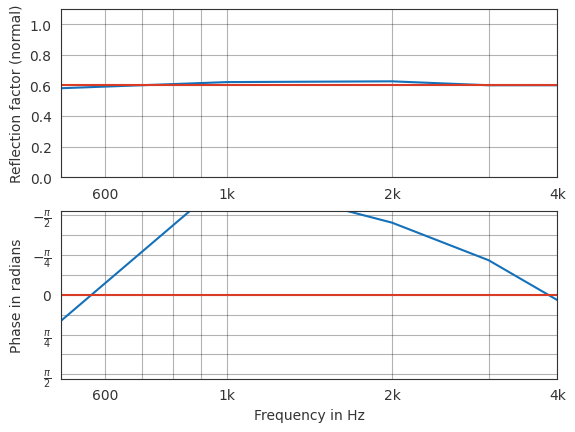

In [92]:

plt.figure()
pf.plot.freq_phase(r_spec[0], dB=False, label='r_spec normal incidence')
ax = pf.plot.freq_phase(
    r_analytical, dB=False, label='analytical normal incidence')
ax[0].set_ylim(0, 1.1)
ax[0].set_ylabel('Reflection factor (normal)')
plt.show()


Furthermore, we can use the oblique incident angles and calculate reflection factor at normal incidence.

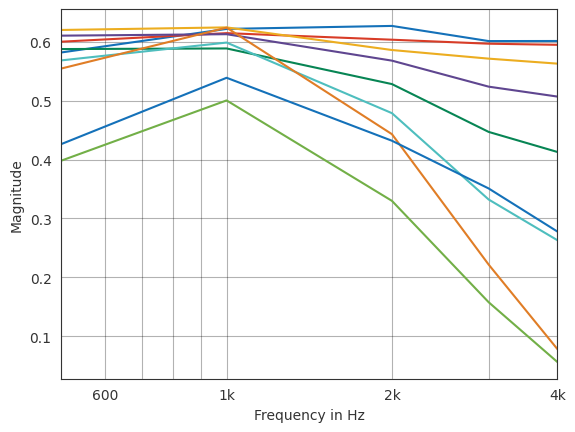

In [93]:
theta = sources.colatitude
plt.figure()
Z_theta = 1//np.cos(theta)*(1 + r_spec)/(1 - r_spec)
r_normal = (Z_theta*np.cos(theta) - 1)/(Z_theta*np.cos(theta) + 1)
pf.plot.freq(
    r_normal, dB=False,
    label='r_spec normal incidence')
plt.show()
